In [5]:
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sys

In [3]:
catalog = pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed", sep='\t')
catalog.set_index(['chr', 'start', 'end'], inplace=True)

In [4]:
benchmark = pd.read_csv("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/GIABTR.HG002.benchmark.regions.bed.gz",
                        sep='\t', names=['chr', 'start', 'end', 'tier', 'repl', 'var_state', 'entropy', 'mat_ad', 'pat_ad'])
benchmark.set_index(['chr', 'start', 'end'], inplace=True)

In [103]:
len(catalog), len(benchmark), len(benchmark) / len(catalog)

(1784804, 1706853, 0.9563251763218819)

In [6]:
data = benchmark[benchmark['tier'] == "Tier1"]
data = data.join(catalog)

In [9]:
data['is_inter'] = data['interspersed'] != '.'


data['motif_length_bin'] = pd.cut(data['max_motif'], bins=[2, 8, 20, 50, 100, sys.maxsize], right=False, 
              labels=["[2, 8)", "[9, 20)", "[21,50)", "[51, 100)", ">100"])
data['max_delta'] = data[['mat_ad','pat_ad']].max(axis=1)
hg002_subset = data['var_state'].apply(lambda x: x & 0x1) == 1

def get_max_motif(x):
    d = json.loads(x)
    return max([len(_['motif']) for _ in d])
data['max_motif'] = data['annos'].apply(get_max_motif)

data['approx_copies'] = data['max_delta'] / data['max_motif']

real_deltas = pd.read_csv("n_ad.txt", sep='\t', names=["chr", "start", "end", "delta"]).set_index(['chr', 'start', 'end'])
data['real_delta'] = real_deltas
data['approx_copies'] = data['real_delta'] / data['max_motif']

Index(['tier', 'repl', 'var_state', 'entropy', 'mat_ad', 'pat_ad', 'ovl_flag',
       'up_buff', 'dn_buff', 'hom_pct', 'n_filtered', 'n_annos',
       'n_subregions', 'mu_purity', 'pct_annotated', 'interspersed', 'patho',
       'codis', 'gene_flag', 'biotype', 'annos'],
      dtype='object')

[Text(0.5, 1.0, 'Motif x Delta (F2c)')]

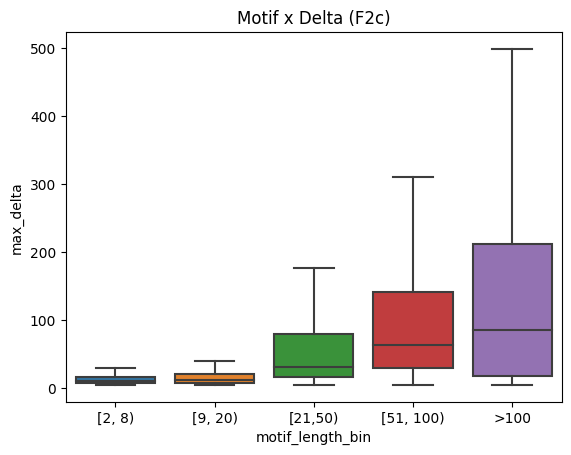

In [101]:
p = sb.boxplot(data=data[hg002_subset & (~data['is_inter'])], x = "motif_length_bin", y="max_delta", showfliers=False)
p.set(title="Motif x Delta (F2c)")

In [ ]:
# There's a general trend that longer motifs create longer expansions/contractions of the region
# However, for regions where the maximum motif is over 100bp, we see an increase in 'partial' copies
# This is possibly due to the maximum motif length annotation being a super-sequence of the  

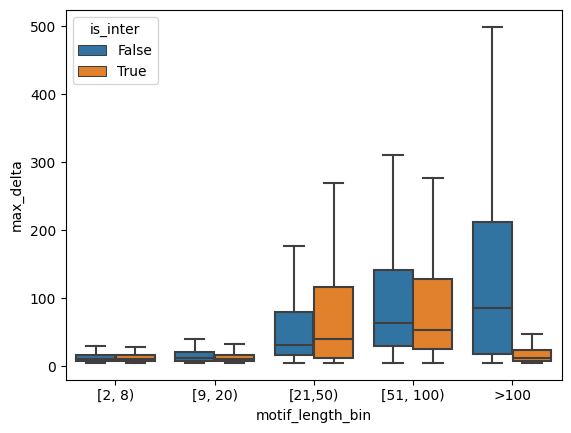

In [70]:
p = sb.boxplot(data=data[hg002_subset], 
               x = "motif_length_bin", 
               y="max_delta", 
               hue='is_inter',
               showfliers=False)

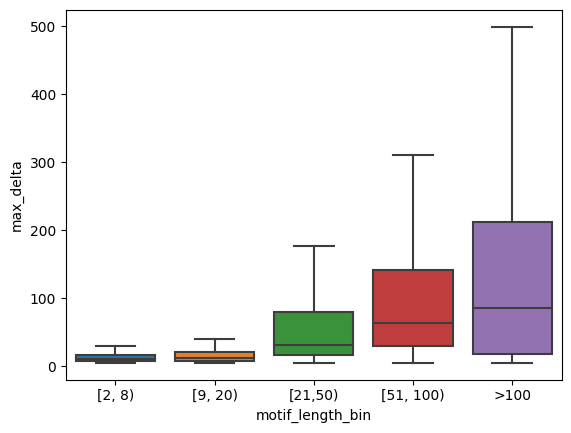

In [73]:
p = sb.boxplot(data=data[hg002_subset & ~data['is_inter']], 
               x = "motif_length_bin",
               y="max_delta", 
               showfliers=False)

In [ ]:
data['is_inter'].value_counts() # Can make another note about these.

False    1552276
True       86232
Name: is_inter, dtype: int64

In [94]:
print((data[hg002_subset & (~data['is_inter'])]['approx_copies'] > 0).sum(),
      (data[hg002_subset & (~data['is_inter'])]['approx_copies'] < 0).sum())

48286 45377


[None, Text(0.5, 1.0, 'approximate expansion/contraction copy number (F2d)')]

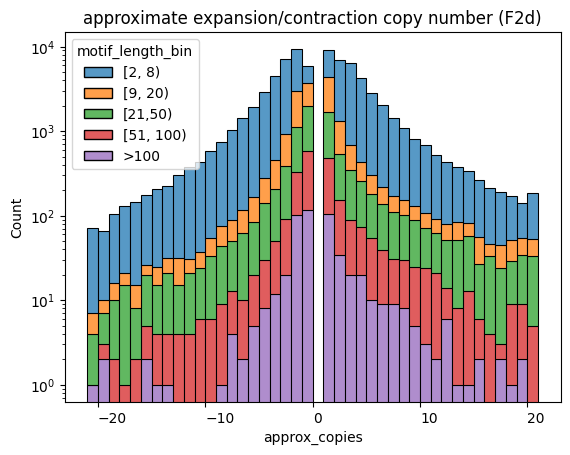

In [102]:
view = data[hg002_subset & (data['approx_copies'].abs().between(1, 21)) & (~data['is_inter'])]
p = sb.histplot(data=view, 
                x='approx_copies', hue="motif_length_bin", 
                multiple='stack', 
                binwidth=1)
plt.xticks(ha='left')
p.set(yscale='log', title="approximate expansion/contraction copy number (F2d)")

# For this we'll be looking for symmetry. 
Though there will be an imbalance at larger allele deltas because contractions are limited to a maximum length of the region's span whereas expansions can continue indefinitley.

[None]

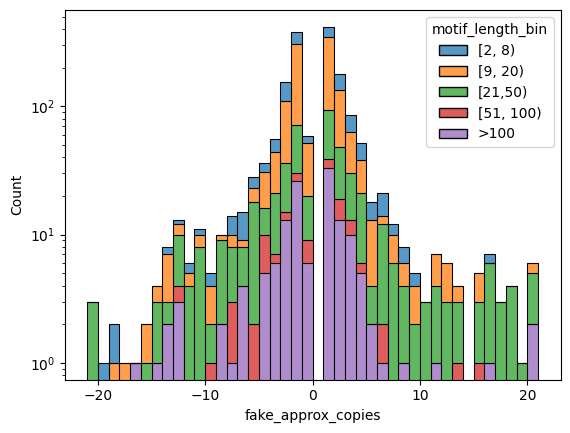

In [96]:
# Why we sometimes want to exclude interspersed repeats
view = data[hg002_subset & (data['approx_copies'].between(1, 21)) & (data['is_inter'])]
p = sb.histplot(data=view, 
                x='fake_approx_copies', hue="motif_length_bin", 
                multiple='stack', 
                binwidth=1)
p.set(yscale='log')

[None]

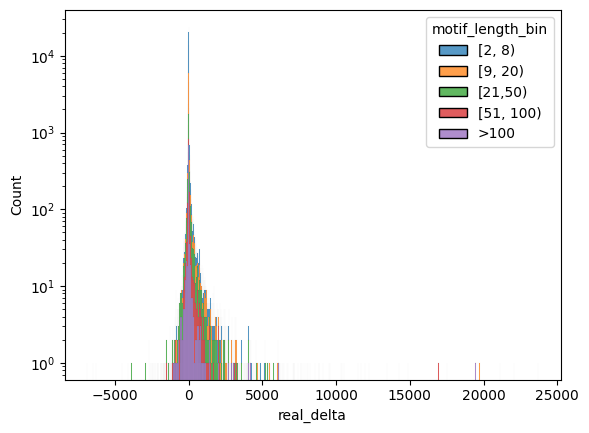

In [99]:
p = sb.histplot(data=data[hg002_subset], x='real_delta', hue='motif_length_bin', binwidth=10, multiple='stack')
p.set(yscale='log')